# Incremental PCA Anomaly Detection with k-means clusterisation

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

## Load the data

In [2]:
data = pd.read_csv('./data/arp_mitm/ARP_MitM_dataset.csv', dtype=np.float32)
labels = pd.read_csv('./data/arp_mitm/ARP_MitM_labels.csv',index_col=0, dtype=np.int32)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2504266 entries, 0 to 2504265
Columns: 115 entries, 1.000000000000000000e+00 to 0.000000000000000000e+00.54
dtypes: float32(115)
memory usage: 1.1 GB


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2504267 entries, 1 to 2504267
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   x       int32
dtypes: int32(1)
memory usage: 28.7 MB


In [5]:
data.head(5)

,1.000000000000000000e+00,1.294000000000000000e+03,0.000000000000000000e+00,1.000000000000000000e+00.1,1.294000000000000000e+03.1,0.000000000000000000e+00.1,1.000000000000000000e+00.2,1.294000000000000000e+03.2,0.000000000000000000e+00.2,1.000000000000000000e+00.3,...,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,1.000000000000000000e+00.24,1.294000000000000000e+03.28,0.000000000000000000e+00.51,1.294000000000000000e+03.29,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54
0,1.000000,1514.0,0.000000e+00,1.000000,1514.0,0.000000e+00,1.000000,1514.0,0.000000e+00,1.000000,...,0.000000e+00,0.0,0.0,1.000000,1514.0,0.000000,1514.0,0.000000e+00,0.0,0.0
1,1.999505,1294.0,6.984919e-10,1.999703,1294.0,2.328306e-10,1.999901,1294.0,6.984919e-10,1.999990,...,0.000000e+00,0.0,0.0,1.999999,1294.0,0.000000,1294.0,0.000000e+00,0.0,0.0
2,2.998985,1294.0,9.313226e-10,2.999391,1294.0,4.656613e-10,2.999797,1294.0,6.984919e-10,2.999980,...,6.984919e-10,0.0,0.0,2.999998,1294.0,0.000015,1294.0,2.328306e-10,0.0,0.0
3,3.998061,1294.0,9.313226e-10,3.998836,1294.0,2.328306e-10,3.999612,1294.0,6.984919e-10,3.999961,...,2.328306e-10,0.0,0.0,3.999996,1294.0,0.000000,1294.0,0.000000e+00,0.0,0.0
4,4.996578,1294.0,6.984919e-10,4.997946,1294.0,4.656613e-10,4.999315,1294.0,0.000000e+00,4.999931,...,4.656613e-10,0.0,0.0,4.999993,1294.0,0.000000,1294.0,0.000000e+00,0.0,0.0


In [6]:
labels.head(5)

,x
1,0
2,0
3,0
4,0
5,0


In [7]:
data.describe()

,1.000000000000000000e+00,1.294000000000000000e+03,0.000000000000000000e+00,1.000000000000000000e+00.1,1.294000000000000000e+03.1,0.000000000000000000e+00.1,1.000000000000000000e+00.2,1.294000000000000000e+03.2,0.000000000000000000e+00.2,1.000000000000000000e+00.3,...,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,1.000000000000000000e+00.24,1.294000000000000000e+03.28,0.000000000000000000e+00.51,1.294000000000000000e+03.29,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54
count,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,...,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06
mean,3.161842e+02,1.263430e+03,1.629564e+05,5.206961e+02,1.263908e+03,1.624292e+05,1.542138e+03,1.264399e+03,1.618283e+05,1.508209e+04,...,1.618793e+05,-2.279081e-03,-7.277524e-07,2.433348e+04,1.264685e+03,3.848150e+02,1.319794e+03,1.617353e+05,-2.131456e-03,-5.309280e-07
std,1.261310e+02,2.731945e+02,4.387120e+04,2.018027e+02,2.730517e+02,4.250526e+04,5.917657e+02,2.729755e+02,4.140191e+04,5.965269e+03,...,4.570886e+04,1.849400e+00,6.071146e-04,6.679178e+03,2.771984e+02,1.050555e+02,7.498083e+01,4.563688e+04,1.538249e+00,5.666413e-04
min,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,...,0.000000e+00,-1.464452e+03,-4.688243e-01,1.000000e+00,6.000000e+01,0.000000e+00,6.000000e+01,0.000000e+00,-8.329919e+02,-2.887022e-01
25%,1.893585e+02,1.302018e+03,1.490106e+05,3.071748e+02,1.301232e+03,1.466209e+05,8.890711e+02,1.297967e+03,1.435192e+05,8.741032e+03,...,1.793071e+05,0.000000e+00,0.000000e+00,2.347741e+04,1.335240e+03,4.248047e+02,1.335240e+03,1.804590e+05,0.000000e+00,0.000000e+00
50%,3.604484e+02,1.328082e+03,1.727128e+05,6.178137e+02,1.331693e+03,1.754399e+05,1.921768e+03,1.336063e+03,1.789780e+05,1.945002e+04,...,1.809940e+05,0.000000e+00,0.000000e+00,2.763520e+04,1.340819e+03,4.254162e+02,1.340819e+03,1.809789e+05,0.000000e+00,0.000000e+00
75%,4.041042e+02,1.342751e+03,1.882200e+05,6.662270e+02,1.342305e+03,1.863478e+05,1.974742e+03,1.341165e+03,1.843493e+05,1.964070e+04,...,1.821485e+05,0.000000e+00,0.000000e+00,2.802381e+04,1.341263e+03,4.259398e+02,1.341263e+03,1.814248e+05,0.000000e+00,0.000000e+00
max,5.365876e+02,1.514000e+03,4.942291e+05,8.073135e+02,1.514000e+03,4.948259e+05,2.124893e+03,1.514000e+03,4.953075e+05,1.983936e+04,...,4.257562e+05,7.038126e+01,8.482200e-02,3.091260e+04,1.514000e+03,6.525000e+02,1.514000e+03,4.257562e+05,3.335587e+02,1.560442e-01


## Scale the data

In [8]:
# scale the data
scaler = pp.StandardScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
count,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,...,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06,2.504266e+06
mean,1.083966e-08,2.851579e-09,-8.530366e-09,3.229353e-10,-4.911053e-09,-1.535466e-09,-1.157693e-08,-6.473938e-09,6.385588e-09,2.488430e-08,...,-8.365851e-09,9.855619e-10,1.671799e-10,1.932250e-07,-1.136405e-08,-1.336525e-08,-1.103616e-09,-5.456387e-09,1.531467e-09,-1.561362e-11
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.498866e+00,-4.405028e+00,-3.714430e+00,-2.575269e+00,-4.409085e+00,-3.821389e+00,-2.604304e+00,-4.412116e+00,-3.908716e+00,-2.528148e+00,...,-3.541532e+00,-7.918514e+02,-7.722161e+02,-3.643037e+00,-4.345931e+00,-3.662969e+00,-1.680155e+01,-3.543964e+00,-5.415183e+02,-5.094965e+02
25%,-1.005510e+00,1.412495e-01,-3.178832e-01,-1.058070e+00,1.366912e-01,-3.719123e-01,-1.103590e+00,1.229701e-01,-4.422288e-01,-1.062995e+00,...,3.812793e-01,1.232335e-03,1.198707e-03,-1.281708e-01,2.545306e-01,3.806518e-01,2.060031e-01,4.102741e-01,1.385638e-03,9.369738e-04
50%,3.509367e-01,2.366555e-01,2.223868e-01,4.812503e-01,2.482510e-01,3.060983e-01,6.415220e-01,2.625269e-01,4.142249e-01,7.322295e-01,...,4.181847e-01,1.232335e-03,1.198707e-03,4.943288e-01,2.746561e-01,3.864726e-01,2.804053e-01,4.216664e-01,1.385638e-03,9.369738e-04
75%,6.970516e-01,2.903494e-01,5.758576e-01,7.211547e-01,2.871150e-01,5.627237e-01,7.310404e-01,2.812183e-01,5.439616e-01,7.641943e-01,...,4.434421e-01,1.232335e-03,1.198707e-03,5.525125e-01,2.762581e-01,3.914571e-01,2.863280e-01,4.314354e-01,1.385638e-03,9.369738e-04
max,1.747416e+00,9.171873e-01,7.551028e+00,1.420286e+00,9.159153e-01,7.820133e+00,9.847738e-01,9.143703e-01,8.054685e+00,7.974971e-01,...,5.772995e+00,3.805750e+01,1.397146e+02,9.850183e-01,8.994111e-01,2.548033e+00,2.590077e+00,5.785254e+00,2.168445e+02,2.753854e+02


## Train-Test Split

In [9]:
# drop the last row
labels=labels[:-1]
labels.tail(5)

,x
2504262,1
2504263,1
2504264,1
2504265,1
2504266,1


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=False, test_size=0.3)

In [11]:
print(f'Number anomalies in train data: {y_train.sum()}')

Number anomalies in train data: x    430423
dtype: int64


In [12]:
print(f'Number anomalies in test data: {y_test.sum()}')

Number anomalies in test data: x    714848
dtype: int64


## Clustering with K-means

In [13]:
kmeans = MiniBatchKMeans(n_clusters=32, n_init=3, max_iter=10, batch_size=2048)
kmeans.fit(X_train)

MiniBatchKMeans(batch_size=2048, max_iter=10, n_clusters=32)

In [14]:
X_train_clust = kmeans.transform(X_train)
print(X_train_clust.shape)

(1752986, 32)


## Train Incremental PCA

In [26]:
# create and fit pca
ipca = IncrementalPCA(n_components=10, batch_size=2048)
ipca.fit(X_train_clust)
train_ipca = ipca.transform(X_train_clust)

In [27]:
inverse_train = ipca.inverse_transform(train_ipca)

In [28]:
def reconstr_error(original, reconstr):
    errors = np.sqrt(np.sum((original - reconstr)**2, axis=1))
    return errors

In [29]:
errors = reconstr_error(X_train_clust, inverse_train)

In [30]:
# average precision score train
aps_train = average_precision_score(y_train, errors)
print(f'Average precision score for train: {aps_train:.4f}')

Average precision score for train: 0.2851


## Test Incremental PCA

In [31]:
X_test_clust = kmeans.transform(X_test)

In [32]:
test_ipca = ipca.transform(X_test_clust)
inverse_test = ipca.inverse_transform(test_ipca)

In [33]:
test_errors = reconstr_error(X_test_clust, inverse_test)

In [34]:
# average precision score test
aps_test = average_precision_score(y_test, test_errors)
print(f'Average precision score for test: {aps_test:.4f}')

Average precision score for test: 0.9563


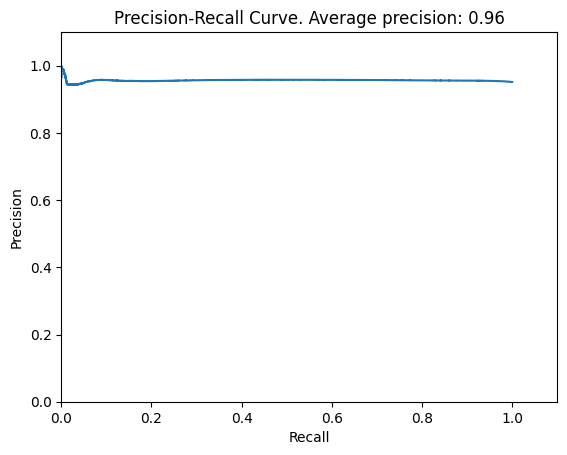

In [35]:
# precision-recall curve for test results
precision, recall, thresholds = precision_recall_curve(y_test, test_errors)
plt.title(f'Precision-Recall Curve. Average precision: {aps_test:.2f}')
plt.xlabel('Recall')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Precision')
#plt.ylim([0, 1.1])
#plt.xlim([0, 1.0])
plt.plot(recall, precision)
plt.show()

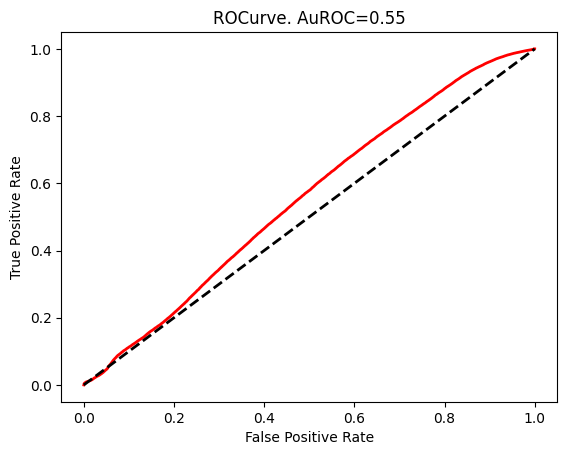

In [25]:
# receiver operational characteristic
fpr, tpr, thresholds = roc_curve(y_test, test_errors)
auROC = auc(fpr, tpr)
plt.figure()
plt.title(f'ROCurve. AuROC={auROC:.2f}')
plt.plot(fpr, tpr, color='r', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], color='k', lw=2, linestyle='--')
plt.show()